In [23]:
import os
import rasterio

In [2]:
input_images = [img for img in os.listdir('images') if img.endswith('.jpg')]
print(input_images[:5])

inpath = 'images'
outpath = 'images/tif'

['J-29-C-2-P-9.jpg', 'J-29-C-5-M-4.jpg', 'J-29-C-3-O-9.jpg', 'J-29-C-5-M-2.jpg', 'J-29-C-2-O-7.jpg']


In [3]:
if not os.path.isdir(outpath):
    os.makedirs(outpath)
    print('Directory was created')
else:
    print('Directory already exists')

Directory was created


In [4]:
kwargs = {
    'driver': 'GTiff',
    'dtype': 'float32',
    'crs': 'EPSG:32721', 
    'nodata': 0,
    'compress': 'lzw',
    'count': 3
}

for img in input_images:
    input_file = os.path.join(inpath, img)
    output_file = os.path.join(outpath, img.replace('.jpg', '.tif'))

    raster = rasterio.open(input_file)

    out_meta = raster.meta.copy()
    out_meta.update(kwargs)

    with rasterio.open(
        output_file,
        mode= 'w',
        **out_meta
    ) as dst:
        dst.write_band(1, raster.read(1))
        dst.write_band(2, raster.read(2))
        dst.write_band(3, raster.read(3))

## Vector masking

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show
import geopandas as gpd
from rasterio import features

In [20]:
# Read in vector
vector = gpd.read_file("input_vector_data/labels.geojson")

# Get list of geometries for all features in vector file
geom = [shapes for shapes in vector.geometry]

<AxesSubplot:>

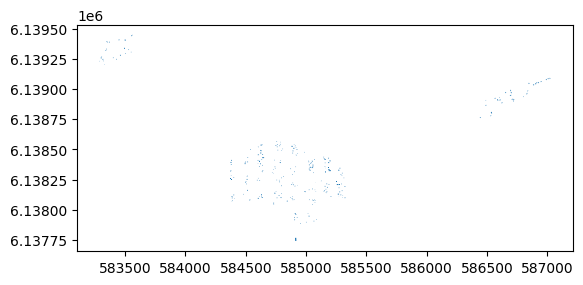

In [22]:
vector.plot()

In [7]:
input_tif = 'images/tif/J-29-C-5-M-9.tif'

raster = rasterio.open(input_tif)

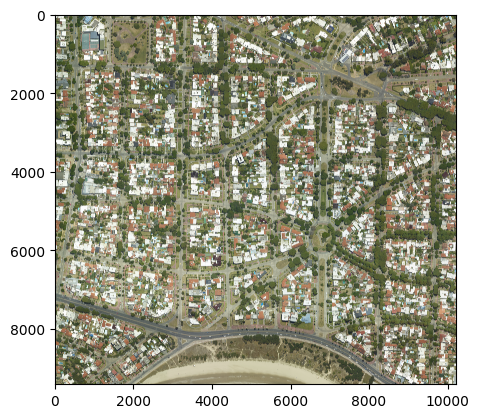

In [16]:
# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(raster.read(1))
greenn = normalize(raster.read(2))
bluen = normalize(raster.read(3))

rgb = np.dstack((redn, greenn, bluen))

# Let's see how our color composite looks like
plt.imshow(rgb)

In [17]:
metadata = raster.meta.copy()
metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 10223,
 'height': 9411,
 'count': 3,
 'crs': CRS.from_epsg(32721),
 'transform': Affine(0.1, 0.0, 584006.8766699999,
        0.0, -0.1, 6138819.79242)}

In [27]:
metadata['transform']

Affine(0.1, 0.0, 584006.8766699999,
       0.0, -0.1, 6138819.79242)

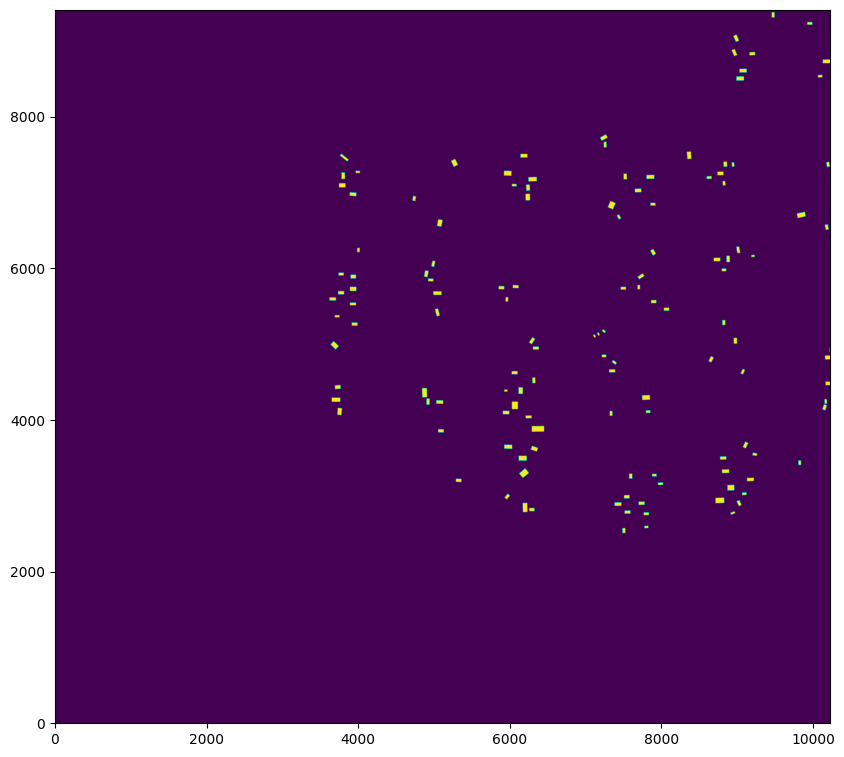

In [30]:
# Rasterize vector using the shape and coordinate system of the raster
rasterized = features.rasterize(geom,
                                out_shape = raster.shape,
                                fill = 0,
                                out = None,
                                transform = raster.transform,
                                all_touched = False,
                                default_value = 1,
                                dtype = None)

# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(rasterized, ax = ax)
plt.gca().invert_yaxis()